In [4]:
import matplotlib.pyplot as plt
import glob
import numpy as np
import pandas as pd
import gzip
import shutil
from Bio import SeqIO


#TODO: Replace this with an import from another file.
import torch
from torch import nn
import umap
GPU_PRESENT = [torch.cuda.device (i) for i in range (torch.cuda.device_count ())]!=[]
print("GPU Detected?: "+str(GPU_PRESENT))
    
def get_device():
    if GPU_PRESENT:
        return(torch.device('cuda'))
    if torch.backends.mps.is_available():
        return(torch.device('mps'))
    else:
        return torch.device("cpu")
device = get_device()
torch.set_default_device(device)
print(f"Using {device.type} device")
    #import cupy as cp


class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            #torch.nn.Conv1d(PAD_SIZE, 400, 1),
            #torch.nn.ReLU(),
            
            torch.nn.Conv1d(PAD_SIZE, 800, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(800, 400, 1),
            torch.nn.ReLU(),
            
            torch.nn.Conv1d(400, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 64, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 16, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 16, 1)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Conv1d(16, 16, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 64, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(128, 400, 1),
            torch.nn.ReLU(),
            
            torch.nn.Conv1d(400, 800, 1),
            torch.nn.ReLU(),
            torch.nn.Conv1d(800, PAD_SIZE, 1),
            torch.nn.Sigmoid()
            
            #torch.nn.Conv1d(400, PAD_SIZE, 1, 1),
            #torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
INPUT_SHAPE=1000
PAD_SIZE=INPUT_SHAPE
model = AE()
model.load_state_dict(torch.load('./RNA_Autoencoder.state_dict'))
model.to(device)
model.eval()

GPU Detected?: True
Using cuda device


AE(
  (encoder): Sequential(
    (0): Conv1d(1000, 800, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(800, 400, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(400, 128, kernel_size=(1,), stride=(1,))
    (5): ReLU()
    (6): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
    (7): ReLU()
    (8): Conv1d(64, 16, kernel_size=(1,), stride=(1,))
    (9): ReLU()
    (10): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
  )
  (decoder): Sequential(
    (0): Conv1d(16, 16, kernel_size=(1,), stride=(1,))
    (1): ReLU()
    (2): Conv1d(16, 64, kernel_size=(1,), stride=(1,))
    (3): ReLU()
    (4): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (5): ReLU()
    (6): Conv1d(128, 400, kernel_size=(1,), stride=(1,))
    (7): ReLU()
    (8): Conv1d(400, 800, kernel_size=(1,), stride=(1,))
    (9): ReLU()
    (10): Conv1d(800, 1000, kernel_size=(1,), stride=(1,))
    (11): Sigmoid()
  )
)

In [5]:
# This could be a utility script

fastqs = glob.glob("/home/grant/NNRNA/fastqs/*/*.fastq.gz")

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
hotkeys = ["A","T", "C", "G"]
hotvals = enc.fit_transform(np.array(hotkeys).reshape(-1,1)).toarray()

def parse_read(record, pad_size=PAD_SIZE):
    x_in = np.array(list(record))
    arr = enc.fit_transform(x_in.reshape(-1,1)).toarray()
    delta = len(arr)-pad_size
    if delta>0:
        #random crop
        shift=np.random.randint(0,delta)
        x_out = arr[shift:shift+pad_size]

    else:
        arr.resize((pad_size, 4), refcheck=False)
        x_out=arr
    return x_out

def seq_to_embedding(seq):
    seq = parse_read(seq)
    seq = torch.tensor(seq).to(torch.float)
    embedding = model.encoder(seq).cpu().detach().numpy().flatten()
    return embedding

def get_embeddings(file, max_size=1e4):
    seqs = {}
    with gzip.open(file, 'rt') as fastq:
        for index, record in enumerate(SeqIO.parse(fastq, "fastq")):
            seq = record
            seqs.update({record.id: [record.seq]})
            if index==max_size:
                break
    df = pd.DataFrame.from_dict(seqs, orient='index')
    with torch.no_grad():
        sample = df.apply(seq_to_embedding, axis=1, result_type='expand')
    return sample
    return x_out

def get_metadf(df):
    names = list(df.index)
    for n, m in enumerate(names):
        names[n] = str.split(m, ":")
    metadf = pd.DataFrame(names)
    return metadf

In [6]:
sample = get_embeddings(fastqs[0], max_size=1e5)
metadf = get_metadf(sample)
sample = sample.reset_index(drop=True)

In [7]:
c1 = sample[metadf[4]=='11101']
c2 = sample[metadf[4]=='11102']

In [ ]:
mapper = umap.UMAP(
    n_neighbors=5,
    min_dist=0.5,
    n_components=2,
    metric='euclidean'
)

umapped = mapper.fit(np.concatenate((c1.to_numpy(), c2.to_numpy())))

In [ ]:

sample[["u1", "u2"]]=umapped
import seaborn as sns
sns.scatterplot(x=sample["u1"], y=sample["u2"], hue=sample['cell'])

In [62]:

sample['cell']=get_metadf(sample)[4].to_numpy()
pd.DataFrame(sample.groupby('cell').value_counts()) # We can get gene counts this way with excellent denoising

In [122]:
mapper.transform(sample)

AttributeError: 'UMAP' object has no attribute '_raw_data'

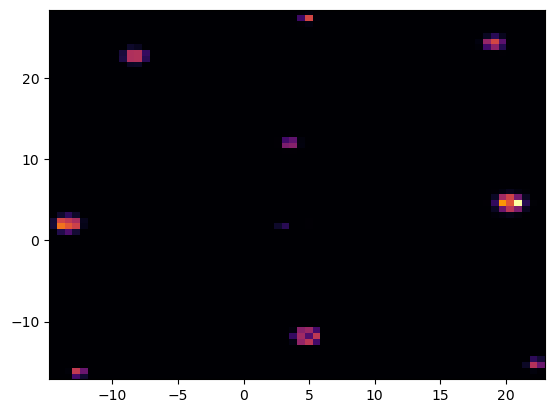

In [104]:
h1=plt.hist2d(x=sample['u1'], y=sample['u2'], bins=64, cmap='inferno')
#u1 = fit.transform(sample1)
#(sample1[sample1['cell']=='11101']['u1'].drop(columns='cell'))=u1[:,0]
#(sample1[sample1['cell']=='11101']['u2'].drop(columns='cell'))=u1[:,1]

<AxesSubplot:xlabel='u1', ylabel='u2'>

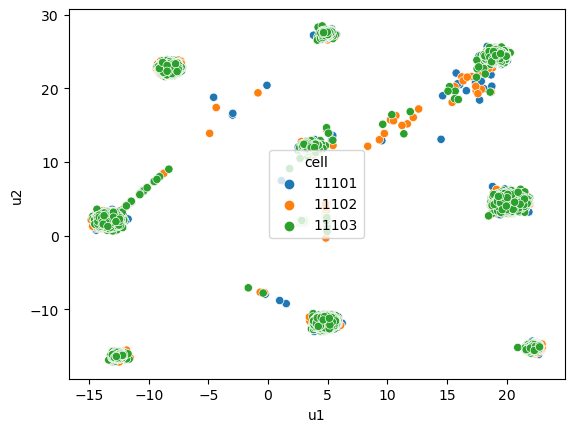

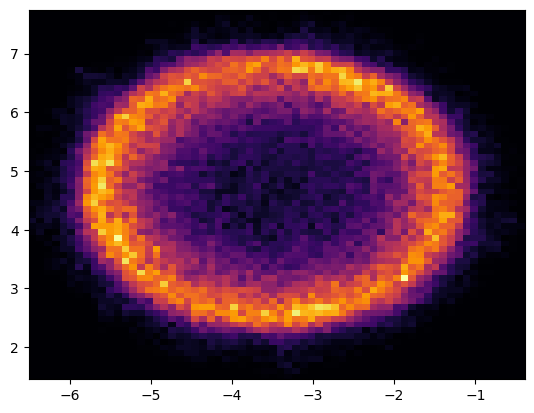

In [59]:
h2=plt.hist2d(x=sample2['u1'], y=sample2['u2'], bins=64, cmap='inferno')

In [57]:
for n, file in enumerate(fastqs):
    subbed = re.sub("fastqs", "encoded", file)
    subbed = re.sub(".fastq.gz", ".csv", subbed)
    encoded = get_embeddings(file, max_size=1e5)
    encoded.to_csv(subbed)
    print("Finished: "+str(n)+" Of "+str(len(fastqs)))

Finished: 0 Of 1152
Finished: 1 Of 1152
Finished: 2 Of 1152
Finished: 3 Of 1152
Finished: 4 Of 1152
Finished: 5 Of 1152
Finished: 6 Of 1152
Finished: 7 Of 1152
Finished: 8 Of 1152
Finished: 9 Of 1152
Finished: 10 Of 1152
Finished: 11 Of 1152
Finished: 12 Of 1152
Finished: 13 Of 1152
Finished: 14 Of 1152
Finished: 15 Of 1152
Finished: 16 Of 1152
Finished: 17 Of 1152
Finished: 18 Of 1152
Finished: 19 Of 1152
Finished: 20 Of 1152
Finished: 21 Of 1152
Finished: 22 Of 1152
Finished: 23 Of 1152
Finished: 24 Of 1152
Finished: 25 Of 1152
Finished: 26 Of 1152
Finished: 27 Of 1152
Finished: 28 Of 1152
Finished: 29 Of 1152
Finished: 30 Of 1152
Finished: 31 Of 1152
Finished: 32 Of 1152
Finished: 33 Of 1152
Finished: 34 Of 1152
Finished: 35 Of 1152
Finished: 36 Of 1152
Finished: 37 Of 1152
Finished: 38 Of 1152
Finished: 39 Of 1152
Finished: 40 Of 1152
Finished: 41 Of 1152
Finished: 42 Of 1152
Finished: 43 Of 1152
Finished: 44 Of 1152
Finished: 45 Of 1152
Finished: 46 Of 1152
Finished: 47 Of 1152
Fi

Finished: 378 Of 1152
Finished: 379 Of 1152
Finished: 380 Of 1152
Finished: 381 Of 1152
Finished: 382 Of 1152
Finished: 383 Of 1152
Finished: 384 Of 1152
Finished: 385 Of 1152
Finished: 386 Of 1152
Finished: 387 Of 1152
Finished: 388 Of 1152
Finished: 389 Of 1152
Finished: 390 Of 1152
Finished: 391 Of 1152
Finished: 392 Of 1152
Finished: 393 Of 1152
Finished: 394 Of 1152
Finished: 395 Of 1152
Finished: 396 Of 1152
Finished: 397 Of 1152
Finished: 398 Of 1152
Finished: 399 Of 1152
Finished: 400 Of 1152
Finished: 401 Of 1152
Finished: 402 Of 1152
Finished: 403 Of 1152
Finished: 404 Of 1152
Finished: 405 Of 1152
Finished: 406 Of 1152
Finished: 407 Of 1152
Finished: 408 Of 1152
Finished: 409 Of 1152
Finished: 410 Of 1152
Finished: 411 Of 1152
Finished: 412 Of 1152
Finished: 413 Of 1152
Finished: 414 Of 1152
Finished: 415 Of 1152
Finished: 416 Of 1152
Finished: 417 Of 1152
Finished: 418 Of 1152
Finished: 419 Of 1152
Finished: 420 Of 1152
Finished: 421 Of 1152
Finished: 422 Of 1152
Finished: 

Finished: 751 Of 1152
Finished: 752 Of 1152
Finished: 753 Of 1152
Finished: 754 Of 1152
Finished: 755 Of 1152
Finished: 756 Of 1152
Finished: 757 Of 1152
Finished: 758 Of 1152
Finished: 759 Of 1152
Finished: 760 Of 1152
Finished: 761 Of 1152
Finished: 762 Of 1152
Finished: 763 Of 1152
Finished: 764 Of 1152
Finished: 765 Of 1152
Finished: 766 Of 1152
Finished: 767 Of 1152
Finished: 768 Of 1152
Finished: 769 Of 1152
Finished: 770 Of 1152
Finished: 771 Of 1152
Finished: 772 Of 1152
Finished: 773 Of 1152
Finished: 774 Of 1152
Finished: 775 Of 1152
Finished: 776 Of 1152
Finished: 777 Of 1152
Finished: 778 Of 1152
Finished: 779 Of 1152
Finished: 780 Of 1152
Finished: 781 Of 1152
Finished: 782 Of 1152
Finished: 783 Of 1152
Finished: 784 Of 1152
Finished: 785 Of 1152
Finished: 786 Of 1152
Finished: 787 Of 1152
Finished: 788 Of 1152
Finished: 789 Of 1152
Finished: 790 Of 1152
Finished: 791 Of 1152
Finished: 792 Of 1152
Finished: 793 Of 1152
Finished: 794 Of 1152
Finished: 795 Of 1152
Finished: 

Finished: 1119 Of 1152
Finished: 1120 Of 1152
Finished: 1121 Of 1152
Finished: 1122 Of 1152
Finished: 1123 Of 1152
Finished: 1124 Of 1152
Finished: 1125 Of 1152
Finished: 1126 Of 1152
Finished: 1127 Of 1152
Finished: 1128 Of 1152
Finished: 1129 Of 1152
Finished: 1130 Of 1152
Finished: 1131 Of 1152
Finished: 1132 Of 1152
Finished: 1133 Of 1152
Finished: 1134 Of 1152
Finished: 1135 Of 1152
Finished: 1136 Of 1152
Finished: 1137 Of 1152
Finished: 1138 Of 1152
Finished: 1139 Of 1152
Finished: 1140 Of 1152
Finished: 1141 Of 1152
Finished: 1142 Of 1152
Finished: 1143 Of 1152
Finished: 1144 Of 1152
Finished: 1145 Of 1152
Finished: 1146 Of 1152
Finished: 1147 Of 1152
Finished: 1148 Of 1152
Finished: 1149 Of 1152
Finished: 1150 Of 1152
Finished: 1151 Of 1152


In [45]:
import re


'/home/grant/NNRNA/encoded/flowcell3/read-RA_si-ACGAAAGC_lane-004-chunk-002.csv'

In [52]:
!ls /home/grant/NNRNA/encoded

/bin/bash: /home/grant/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
flowcell1  flowcell2  flowcell3


/bin/bash: /home/grant/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
